## **[Week 14] DCGAN**

* Basics for DCGan & Preparation
* CIFAR10 dataset
* Implement DCGAN

**[Important]** \\
The results of the exercises should be included in your weekly report for this practice session.
The weekly report for this session should be submitted to KLMS by this weekend. No late submission would be accepted.

###1. Basics for DCGAN  

#### 1-1. GAN(Generative Adversarial Network)  
We briefly review GAN and DCGAN. GAN sturcture is as follows   
<a href="https://ibb.co/30P7bq1"><img src="https://i.ibb.co/zStrgYs/gan.png" alt="gan" border="0"></a>

Details for GAN structure  
* z: random noise, follows distribution $p_z$
* Generator network: parameterized by $\theta_G$
* Discriminator network: parameterized by $\theta_D$
* Real image(x): follows distribution $p_{real}$  


####About GAN  
####Goal
* Discriminator: The discriminator (D) assigns a label of 1 to real images and 0 to fake images.  
* Generator: The discriminator (D) assigns a label of 1 to fake images which were generated by the generator.  
  
####Loss  
To achieve the goal above, construct loss function as follows
\begin{align}
    V(\theta_D,\theta_G)=\mathbb{E}_{x\sim p_{real}}\log D_{\theta_D}(x) + \mathbb{E}_{z\sim p_Z}\log (1-D_{\theta_D}(G_{\theta_G}(x)))
\end{align}  
  
####Training  
* Discriminator: $\max_{\theta_D}V(\theta_D,\theta_G)$
* Generator: $\min_{\theta_G}V(\theta_D,\theta_G)=\min_{\theta_G}\mathbb{E}_{z\sim p_Z}\log (1-D_{\theta_D}(G_{\theta_G}(x)))$  

####Theoretical result of GAN training  
<a href="https://imgbb.com/"><img src="https://i.ibb.co/7RdrkNS/gans.jpg" alt="gans" border="0"></a>  
Black is for real image(x), green is for fake image(G(z)) from generator and blue(D(G(z))) is prediction from discriminator. Initially, The generator is poor and thus discriminator can tell real and fake images. After training distribution of $G(z)$ become similar to that of $x$ and discriminator always gives probabily 0.5. It means that fake image is sufficiently similar to real data so that discriminator cannot tell them at all.

####Practical technique  
When training the generator there is a practical issue about gradient.  


<ipython-input-1-e7e737bb6c79>:5: RuntimeWarning: divide by zero encountered in log
  y_1 = -np.log(x_plot)
<ipython-input-1-e7e737bb6c79>:6: RuntimeWarning: divide by zero encountered in log
  y_2 = np.log(1-x_plot)


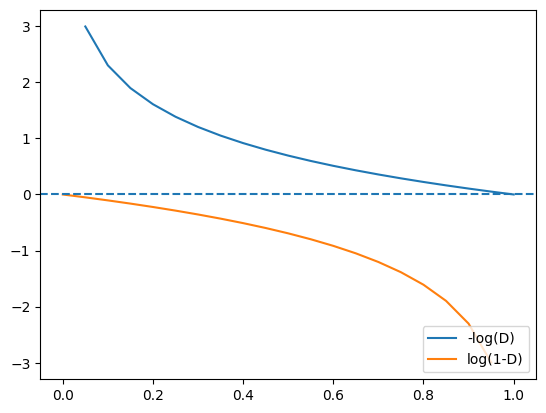

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_plot = np.linspace(0,1,21)
y_1 = -np.log(x_plot)
y_2 = np.log(1-x_plot)
plt.plot(x_plot,y_1, label='-log(D)')
plt.plot(x_plot,y_2, label='log(1-D)')
plt.axhline(y=0,linestyle = '--')
plt.legend(loc='lower right')
plt.show()

At the begining of training, the generator gives poor quality of fake images. It means that $D(G(z))$ is nearly 0. As you can see in the graph, gradient of $\log(1-D)$ is vanished near $D=0$ and it interrupts training of the generator. For this reason, using $-\log D$ instead of $\log(1-D)$ can be helpful.

#### 1-2. DCGAN(Deep Convolutional Generative Adversarial Networks)  
DCGAN is a variant of GAN which uses CNN structure for generator and discriminator. Generally, the generator consists of convolutional layers and the discriminator consists of fractionally-strided convolutional layers.

###2. Preparation

#### 2-1. GPU setup and importing packages

GPU setup  
Make sure you are using the GPU.

In [ ]:
# visualize current GPU usages in your server
# runtme type to GPU
!nvidia-smi

Mon Aug 21 14:14:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# set gpu by number
import os
import random
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # setting gpu number

Import the required packages and fix seed

In [ ]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio #### install with "pip install imageio"
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid



# Set random seeds fixed for reproducibility
seed = 7    # Do NOT change the seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
#torch.use_deterministic_algorithms(True) # Needed for reproducible results

#### 2-2. Visualization  
In this part, we define some tools to visualize our resulting images.

In [ ]:
def save_gif(training_progress_images, images):
    '''
        training_progress_images: list of training images generated each iteration
        images: image that is generated in this iteration
    '''
    img_grid = make_grid(images.data)
    img_grid = np.transpose(img_grid.detach().cpu().numpy(), (1, 2, 0))
    img_grid = (img_grid * 0.5 + 0.5) * 255.0 # img_grid * 0.5 + 0.5
    img_grid = img_grid.astype(np.uint8)
    training_progress_images.append(img_grid)
    imageio.mimsave('./img/training_progress.gif', training_progress_images)
    return training_progress_images

###3. CIFAR10 dataset  


#### 3-1. About CIFAR-10  
The CIFAR-10 dataset is a widely used computer vision benchmark consisting of 60,000 color images across 10 distinct classes, each containing 6,000 images. The dataset in each class is divided into 5,000 training images and 1,000 test images. Images within CIFAR-10 are relatively small, with dimensions of 32x32 pixels, thus show low resolution images.  

#### 3-2. Load CIFAR-10 datasets

In [ ]:
# Create folders
if not os.path.exists('./ee214'):
    os.mkdir('./ee214')

if not os.path.exists('./img'):
    os.mkdir('./img')

Download CIFAR10 dataset and properly transform

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = dset.CIFAR10(root='./ee214', train=True,
    download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

100%|██████████| 170498071/170498071 [00:04<00:00, 39714167.43it/s]


Extracting ./ee214/cifar-10-python.tar.gz to ./ee214


Check the size of CIFAR10 dataset

In [ ]:
print("shape of total dataset: ", dataset.data.shape)
print("length of dataset: ", len(dataset))
print("the first example in the train dataset: ", dataset[0]) # tuple: (img,label)
print("this indicates (image tensor, label)")
print("shape of a single image: ", dataset[0][0].shape)

shape of total dataset:  (50000, 32, 32, 3)
length of dataset:  50000
the first example in the train dataset:  (tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
         [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
         ...,
         [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
         [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
         [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],

    

CIFAR10 image examples

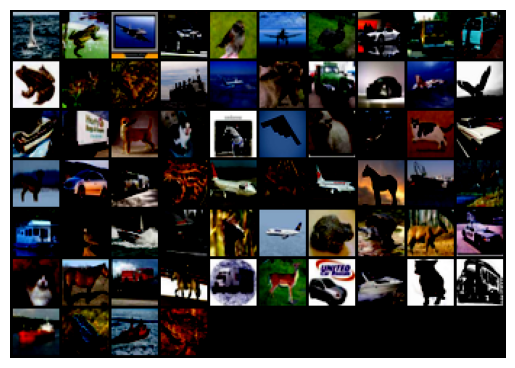

In [ ]:
# Get a batch of images from the dataloader
images, labels = next(iter(dataloader))

# Create a grid of images
grid = vutils.make_grid(images, nrow=10)

# Convert PyTorch tensor to numpy array and transpose dimensions
grid_np = np.transpose(grid.numpy(), (1, 2, 0))

# Display the grid of images using imshow
plt.imshow(grid_np)
plt.axis('off')  # Turn off axes
plt.show()

### 4. Implement DCGan  
In this part, we will implement Deep Convolutional Gan.  
* Construct Generator, Discriminator with CNN structure
* Construct loss function
* Implement main loop

#### 4-1. Generator and Discriminator  
In this part, you will consturct Generator and Discriminator with CNN structure.  
You can use nn.ConvTranspose2d() and nn.Conv2d().

**Exercise 1.**  
Construct generator. Define **self.main** using **nn.Sequential**. Detailed structure is suggested below.  
 The last layer is Tanh activation.  
<a href="https://ibb.co/hmrvm3t"><img src="https://i.ibb.co/gRQCRkB/gen.png" alt="gen" border="0"></a>



In [ ]:
nc = 3 # number of channels, RGB
nz = 100 # input noise dimension
ngf = 64 # number of generator filters
ndf = 64 #number of discriminator filters

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################
        ###### Task 1. Construct generator ####
        ### Define self.main ###
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (1,100,1,1)->(1,ngf * 4, 4, 4)
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. -> 1 x (ngf*2) x 8 x 8
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 32 x 32
            )
        #######################################
        #######################################
    def forward(self, input):
        output = self.main(input)
        return output

**Exercise 2.**  
Construct discriminator. Define **self.main** using **nn.Sequential**. Detailed structure is suggested below.  
<a href="https://ibb.co/Ss93jZ2"><img src="https://i.ibb.co/K03rP8Y/disc.png" alt="disc" border="0"></a>


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        ########################################
        ###### Task 2. Construct discriminator #
        ### Define self.main ###
        self.main =nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4

            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        ########################################
        ########################################
    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

#### 4-2. Make generator and discriminator and define optimizer for each

In [ ]:
netG = Generator().cuda()
netD = Discriminator().cuda()

optimizerD = optim.Adam(netD.parameters(), lr=0.0002)
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
# optimizerD = optim.SGD(netD.parameters(), lr=0.0002)
# optimizerG = optim.SGD(netG.parameters(), lr=0.0002)

In [ ]:
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


Check the size of a single batch

In [ ]:
for i, data in enumerate(dataloader):
  print(data[0].size())
  if i==0:
    break

torch.Size([64, 3, 32, 32])


#### 4-3. Main loop

In [ ]:
fixed_noise = torch.randn(64, 100,1,1).cuda()

criterion = nn.BCELoss()

G_loss_list = list()
D_loss_list = list()

n_epoch = 20
generated_img_list = []

for epoch in range(n_epoch):
    for i, (data, _) in enumerate(dataloader):
        ####################################################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))) #
        ###################################################
        # train with real
        netD.zero_grad()
        data = data.cuda()
        batch_size = data.size(0) #64
        label = torch.ones((batch_size,)).cuda() # real label = 1

        output = netD(data)
        errD_real = criterion(output, label)
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, 100,1,1).cuda()
        fake = netG(noise) # fake image
        label = torch.zeros((batch_size,)).cuda() # fake label = 1
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        D_G_z1 = output.mean().item()

        # Loss backward
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        ########################################
        # (2) Update G network: maximize log(D(G(z))) #
        ########################################
        netG.zero_grad()
        label = torch.ones((batch_size,)).cuda()  # fake labels are real for generator cost

        output = netD(fake)

        errG = criterion(output, label)
        D_G_z2 = output.mean().item()

        errG.backward()
        optimizerG.step()

    print('[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, n_epoch, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    G_loss_list.append(errG.item())
    D_loss_list.append(errD.item())

    #save the output
    fake = netG(fixed_noise)
    generated_img_list = save_gif(generated_img_list, fake)  # Save fake image while training!

[0/20] Loss_D: 0.0709 Loss_G: 5.5866 D(x): 0.9511 D(G(z)): 0.0166 / 0.0052
[1/20] Loss_D: 0.0272 Loss_G: 7.4305 D(x): 0.9919 D(G(z)): 0.0179 / 0.0028
[2/20] Loss_D: 0.1144 Loss_G: 7.8089 D(x): 0.9309 D(G(z)): 0.0138 / 0.0113
[3/20] Loss_D: 0.1304 Loss_G: 7.9491 D(x): 0.9342 D(G(z)): 0.0045 / 0.0040
[4/20] Loss_D: 0.0845 Loss_G: 6.7588 D(x): 0.9853 D(G(z)): 0.0606 / 0.0060
[5/20] Loss_D: 0.1557 Loss_G: 6.2692 D(x): 0.8756 D(G(z)): 0.0050 / 0.0034
[6/20] Loss_D: 0.1058 Loss_G: 4.1676 D(x): 0.9443 D(G(z)): 0.0400 / 0.0303
[7/20] Loss_D: 0.6617 Loss_G: 4.2658 D(x): 0.6817 D(G(z)): 0.0458 / 0.0532
[8/20] Loss_D: 0.5323 Loss_G: 4.5380 D(x): 0.7350 D(G(z)): 0.1030 / 0.0370
[9/20] Loss_D: 0.0922 Loss_G: 5.7959 D(x): 0.9613 D(G(z)): 0.0451 / 0.0092
[10/20] Loss_D: 0.1180 Loss_G: 5.9892 D(x): 0.9292 D(G(z)): 0.0370 / 0.0178
[11/20] Loss_D: 1.1028 Loss_G: 3.2457 D(x): 0.5395 D(G(z)): 0.0085 / 0.0721
[12/20] Loss_D: 0.0417 Loss_G: 6.7172 D(x): 0.9777 D(G(z)): 0.0177 / 0.0105
[13/20] Loss_D: 0.2806

#### 4-4. Results

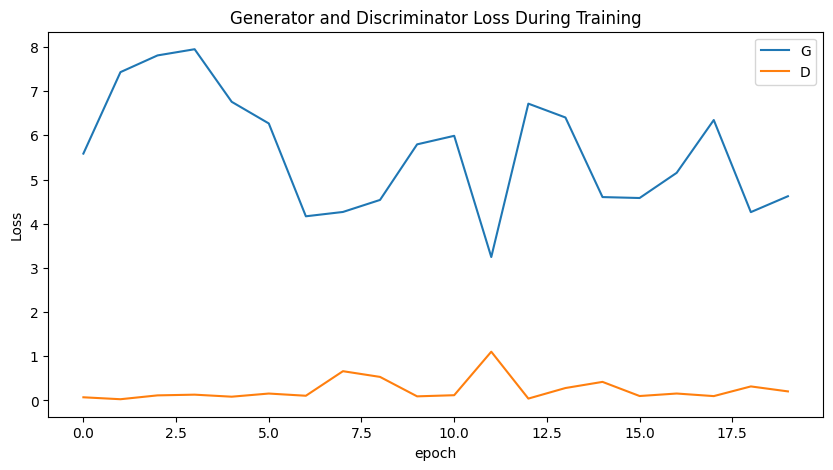

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_loss_list,label="G")
plt.plot(D_loss_list,label="D")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

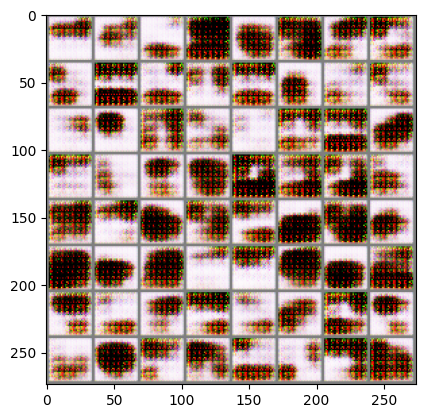

In [ ]:
# compare the generated images at the beginning and end of the training
plt.imshow(generated_img_list[0])
plt.show()

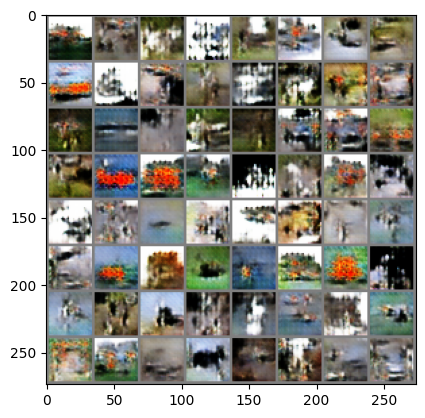

In [ ]:
# compare the generated images at the beginning and end of the training
plt.imshow(generated_img_list[-1])
plt.show()

Double click the training_progress.gif in your img folder. Then you can observe how the fake images generated by your generator model has been improved.

#**References**
https://github.com/nowozin/mlss2018-madrid-gan/blob/master/GAN%20-%20Tiny%20ImageNet%2064x64.ipynb  
https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
https://github.com/Ksuryateja/DCGAN-CIFAR10-pytorch/blob/master/gan_cifar.py